In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## reading the dataset in

In [2]:
dataset_pth = "../datasets/nearest-earth-objects.csv"
df = pd.read_csv(dataset_pth) # dataframe

df.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


## checking all null entries

In [4]:
df.isnull().sum()

neo_id                     0
name                       0
absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
orbiting_body              0
relative_velocity          0
miss_distance              0
is_hazardous               0
dtype: int64

## creating a subset of the original data (don't need to use all of it) -  if no nulls then we don't need to dropna()

In [5]:
df_subset = df.head(300) # selecting a subset of the dataset

df_subset.isnull().sum()

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

## we can count the number of haardous asteroid objects and non-hazardous asteroid objects

In [6]:
df_subset["is_hazardous"].value_counts()

is_hazardous
False    255
True      45
Name: count, dtype: int64

In [7]:
y = df_subset.iloc[:, -1] # set the target set to be only the last column

print(y)

0      False
1       True
2      False
3      False
4      False
       ...  
295     True
296     True
297    False
298    False
299    False
Name: is_hazardous, Length: 300, dtype: bool


In [8]:
df_subset["is_hazardous"].value_counts()

is_hazardous
False    255
True      45
Name: count, dtype: int64

## converting target set Y to 0 or 1 for binary classification

In [9]:
df_subset["is_hazardous"] = df["is_hazardous"].astype(int)

print(df_subset["is_hazardous"])

0      0
1      1
2      0
3      0
4      0
      ..
295    1
296    1
297    0
298    0
299    0
Name: is_hazardous, Length: 300, dtype: int32


C:\Users\zayaa\AppData\Local\Temp\ipykernel_21016\1818337623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["is_hazardous"] = df["is_hazardous"].astype(int)


## creating our feature set and target set

In [10]:
X = df_subset[["absolute_magnitude", "estimated_diameter_max"]]
y = df_subset["is_hazardous"]


print(X)

     absolute_magnitude  estimated_diameter_max
0                 19.14                0.883161
1                 18.50                1.185878
2                 21.45                0.304818
3                 20.63                0.444672
4                 22.70                0.171412
..                  ...                     ...
295               21.10                0.358129
296               21.94                0.243243
297               23.77                0.104722
298               26.78                0.026184
299               24.40                0.078350

[300 rows x 2 columns]


In [11]:
# input_shape = (2, )
# norm_l = tf.keras.layers.Normalization(axis=-1, input_shape=input_shape)
# norm_l.adapt(X)  # learns mean, variance
# Xn = norm_l(X)
# print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
# print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

In [12]:
def relu(x):
    return np.maximum(0, x)

## we define the activation function - we are using sigmoid 

In [13]:
def sigmoid(z): # g = f(x) =  1 / 1 + e^(-z)
    return 1 / (1 + np.exp(-z))

## testing activation to see if initial computation is correct

In [14]:
sigmoid(2)

0.8807970779778823

## Now we define our dense function which computes the activations of the dense layer for forward propagation where dense refers to a NN in which each layer is deeply connected to the prev. layer

In [15]:
# needs to return activation_output which is to be fed to next layer
def dense(activation_input, W, b, activation): # activation_in is X
    units = W.shape[1]
    activation_output = np.zeros(units)
    for j in range(units):
        w = W[:, j] # same as W[j] but for clarity I will keep it as it is
        z = np.dot(w, activation_input) + b[j] # Wx + b
        activation_output = activation(z)
    return activation_output

## Now let's build a very simple 3-layer neural network using dense()

In [16]:
def custom_sequential_model(x, W1, b1, W2, b2, W3, b3):

    activation_layer1 = dense(x, W1, b1, activation=relu) # relu for hidden layer 1
    print("Layer 1 output range:", activation_layer1.min(), activation_layer1.max())
    
    activation_layer2 = dense(activation_layer1, W2, b2, activation=relu) # relu for hidden layer 2
    print("Layer 2 output range:", activation_layer2.min(), activation_layer2.max())
    
    activation_layer3 = dense(activation_layer2, W3, b3, activation=sigmoid) # sigmoid for output layer
    print("Layer 3 output range:", activation_layer3.min(), activation_layer3.max())
    
    return activation_layer3

## setting some random weights and biases

In [17]:
# First hidden layer
W1_tmp = np.array([
    [-0.58,  0.76,  0.91],
    [ 0.23, -0.82, -0.44]
])
b1_tmp = np.array([-0.37,  0.51, -0.63])

# Second hidden layer
W2_tmp = np.array([
    [ 0.71, -0.52,  0.43],
    [-0.33,  0.61,  0.29],
    [ 0.95, -0.79, -0.40]
])
b2_tmp = np.array([0.12, -0.38,  0.76])

# Output layer
W3_tmp = np.array([[-0.86],
                   [ 0.35],
                   [-0.67]
                   ])
b3_tmp = np.array([0.21])


## We can define our predict function which basically makes predictions for each sample (0 or 1) -> (non-hazardous or hazardous)

In [18]:
def predict(X, W1, b1, W2, b2, W3, b3):
    ## m = number of training examples  - rows
    m = X.shape[0]
    p = np.zeros((m, 1)) # predictions buffer - we set to be 0 for each sample initially
    for i in range(m):
        p[i, 0] = custom_sequential_model(X[i], W1, b1, W2, b2, W3, b3)
    return p

## testing our predict function on some random samples I made up

In [19]:
X_test_data = np.array([
    [0.066765941, 0.149293183],
    [0.316632126, 0.708010957]
])
test_predictions = predict(X_test_data, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)

Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935
Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935


In [20]:
print(test_predictions)

[[0.33474531]
 [0.33474531]]


In [21]:
yhat = (test_predictions >= 0.5).astype(int)
print(f"test_predictions:\n {yhat}")

test_predictions:
 [[0]
 [0]]


## Now for the actual predictions

In [22]:
X = np.array(X)
X

array([[1.91400000e+01, 8.83161196e-01],
       [1.85000000e+01, 1.18587791e+00],
       [2.14500000e+01, 3.04817558e-01],
       [2.06300000e+01, 4.44672200e-01],
       [2.27000000e+01, 1.71411509e-01],
       [2.50000000e+01, 5.94346868e-02],
       [2.15000000e+01, 2.97879063e-01],
       [1.97500000e+01, 6.66868155e-01],
       [2.17000000e+01, 2.71668934e-01],
       [2.34500000e+01, 1.21350055e-01],
       [2.60200000e+01, 3.71569432e-02],
       [2.15000000e+01, 2.97879063e-01],
       [2.37600000e+01, 1.05205872e-01],
       [1.67100000e+01, 2.70420729e+00],
       [2.43000000e+01, 8.20427065e-02],
       [2.43200000e+01, 8.12905344e-02],
       [2.49000000e+01, 6.22357573e-02],
       [2.17200000e+01, 2.69178258e-01],
       [1.73600000e+01, 2.00465656e+00],
       [1.92900000e+01, 8.24213984e-01],
       [2.39000000e+01, 9.86370281e-02],
       [2.24500000e+01, 1.92326877e-01],
       [1.77700000e+01, 1.65973969e+00],
       [2.45000000e+01, 7.48238376e-02],
       [2.182000

## Forgot to normalize through preprocessing above, do that now to avoid skewed range of data

In [23]:
# normalized_layer = tf.keras.layers.Normalization(axis=-1)  # found that sklearn.preprocessing.StandardScalar works better

# print(normalized_layer)


In [24]:
# normalized_layer.adapt(X)

# X_normalized = normalized_layer(X)

# print(X_normalized)

In [25]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_normalized = scalar.fit_transform(X)

## creating predictions using our custom model

In [26]:
predictions = predict(X_normalized, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)

predictions

Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935
Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935
Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935
Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935
Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935
Layer 1 output range: 0.5909851172515893 0.5909851172515893
Layer 2 output range: 0.5236059530993643 1.0141236004181833
Layer 3 output range: 0.33470582589400094 0.33470582589400094
Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 output range: 0.33474530683702935 0.33474530683702935
Layer 1 output range: 0.0 0.0
Layer 2 output range: 0.76 0.76
Layer 3 outp

array([[0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33470583],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474423],
       [0.33468158],
       [0.33474531],
       [0.33473634],
       [0.33474531],
       [0.33472287],
       [0.33472238],
       [0.33470824],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33473282],
       [0.33474531],
       [0.33474531],
       [0.33471796],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33471796],
       [0.33466175],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.30401273],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33473862],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.33474531],
       [0.334

In [27]:
yhat = (predictions >= 0.5).astype(int)
print(f"Actual predictions:\n {yhat}")

Actual predictions:
 [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]

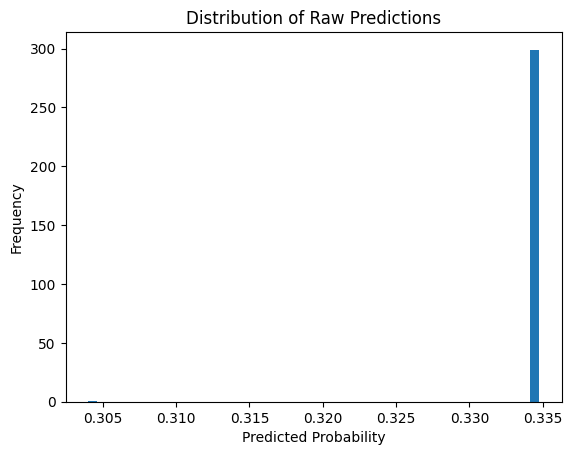

In [28]:
plt.hist(predictions, bins=50)
plt.title('Distribution of Raw Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()